# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [1]:
# Q1 (code)
!pip install tomotopy

In [2]:
!pip install little_mallet_wrapper

In [3]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [4]:
# Q2 (code)
# Load the datasets
trump_tweets_df = pd.read_csv("trump_tweets.csv")  
sanders_tweets_df = pd.read_csv("sanders_tweets.csv")

# Check the structure of the datasets
print("Trump tweets shape:", trump_tweets_df.shape)
print("Sanders tweets shape:", sanders_tweets_df.shape)

# Concatenate the datasets
combined_tweets_df = pd.concat([trump_tweets_df, sanders_tweets_df], ignore_index=True)

# Check the shape of the combined dataset
print("Combined tweets shape:", combined_tweets_df.shape)


Trump tweets shape: (23075, 4)
Sanders tweets shape: (7296, 4)
Combined tweets shape: (30371, 4)


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [5]:
# Q3 (code)
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK resources (if not already downloaded)
nltk.download('stopwords')
nltk.download('punkt')

# Define stopwords and compile regex for punctuation and numbers
stop_words = set(stopwords.words('english'))
punctuation = re.compile(r'[^\w\s]')
numbers = re.compile(r'\b\d+\b')

# Function to clean and preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, user mentions, and "realdonaldtrump"
    text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = punctuation.sub('', text)
    # Remove numbers
    text = numbers.sub('', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into text
    clean_text = ' '.join(filtered_tokens)
    return clean_text

# Initialize lists
training_data = []
original_texts = []
titles = []

# Iterate through the combined dataset
for index, row in combined_tweets_df.iterrows():
    author = row['Username']  #  'Username' is the column containing the author's name
    tweet_id = row['TweetId']  #  'TweetId' is the column containing the tweet ID
    text = row['Content']  #  'Content' is the column containing the tweet content
    
    # Clean and preprocess text
    clean_text = preprocess_text(text)
    
    # Add processed text to training_data list
    training_data.append(clean_text)
    
    # Add original text to original_texts list
    original_texts.append(text)
    
    # Create title to identify author and tweet ID
    title = f"{author}_ID:{tweet_id}"
    titles.append(title)

# Print a few examples of processed text, original text, and titles
for i in range(5):
    print("Processed text:", training_data[i])
    print("Original text:", original_texts[i])
    print("Title:", titles[i])
    print()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huangyuxin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/huangyuxin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processed text: begins today see swearingin movement continues work begins
Original text:  It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - THE WORK BEGINS!
Title: @realDonaldTrump_ID:822421390125043713

Processed text: today merely transferring power one administration another one party another äì transferring
Original text:  Today we are not merely transferring power from one Administration to another, or from one party to another‚ Äì but we are transferring...
Title: @realDonaldTrump_ID:822501803615014918

Processed text: power washington dc giving back american people inaugurationday
Original text:  power from Washington, D.C. and giving it back to you, the American People. # InaugurationDay
Title: @realDonaldTrump_ID:822501939267141634

Processed text: truly matters party controls government whether government controlled people
Original text:  What truly matters is not which party controls our government, but whether our government is

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [6]:
# Q4 (code)
import tomotopy as tp

# Number of topics to return
num_topics = 15
# Number of topic words to print out
num_topic_words = 10

# Initialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n")

# Training the model
total_iterations = 100
iterations_per_step = 10

for i in range(0, total_iterations, iterations_per_step):
    model.train(iterations_per_step)
    print(f'Iteration: {i+iterations_per_step}\tLog-likelihood: {model.ll_per_word:.6f}')


Topic Model Training...

Iteration: 10	Log-likelihood: -9.316653
Iteration: 20	Log-likelihood: -8.926594
Iteration: 30	Log-likelihood: -8.739449
Iteration: 40	Log-likelihood: -8.639474
Iteration: 50	Log-likelihood: -8.578980
Iteration: 60	Log-likelihood: -8.534877
Iteration: 70	Log-likelihood: -8.501225
Iteration: 80	Log-likelihood: -8.477281
Iteration: 90	Log-likelihood: -8.459406
Iteration: 100	Log-likelihood: -8.442039


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [7]:
# Q5a (code)
# Print out top words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")



Topic Model Results:


✨Topic 0✨

trump republicans people tax security want republican social bill american

✨Topic 1✨

great president north korea meeting forward amp united thank states

✨Topic 2✨

health care people must right country change every climate need

✨Topic 3✨

border wall amp democrats immigration law security must illegal country

✨Topic 4✨

rt trump president biden amp coronavirus joe donald new covid19

✨Topic 5✨

rt election pm tonight watch news live house votes voter

✨Topic 6✨

rt trump fbi russia collusion amp campaign witch hunt obama

✨Topic 7✨

rt democrats impeachment president house nothing pelosi senate schiff call

✨Topic 8✨

great rt thank america american today day country court amp

✨Topic 9✨

never amp many said would people time even john like

✨Topic 10✨

workers pay americans jobs million tax billion people wage drug

✨Topic 11✨

us china much many states trade deal united would back

✨Topic 12✨

news fake media amp people biden joe even would bad

In [8]:
print("Number of topics in the model:", model.k) #To confirm the number of topic in the model

Number of topics in the model: 15


In [46]:
# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?

##Topic 0: Republican Policies - This topic seems to revolve around Republican policies and agendas, mentioning keywords like "trump", "republicans", "tax", "security", and "american".

##Topic 1: International Relations - This topic appears to discuss international relations, including keywords like "president", "north korea", "meeting", "united", and "states".

##Topic 2: Healthcare and Climate Change - This topic likely focuses on healthcare and climate change issues, mentioning keywords such as "health care", "country", "change", "climate", and "need".

##Topic 3: Immigration and Border Security - This topic seems to discuss immigration and border security matters, including keywords like "border", "wall", "immigration", "security", and "illegal".

##Topic 4: COVID-19 and Politics - This topic may be about COVID-19 and political figures, mentioning keywords like "trump", "president", "biden", "coronavirus", and "covid19".

##Topic 5: Election News - This topic likely discusses election-related news, including keywords such as "election", "pm", "watch", "news", and "voter".

##Topic 6: Trump and Russia Investigation - This topic appears to revolve around Trump and the Russia investigation, mentioning keywords like "trump", "fbi", "russia", "collusion", and "campaign".

##Topic 7: Impeachment Proceedings - This topic seems to discuss impeachment proceedings, mentioning keywords like "democrats", "impeachment", "president", "house", and "senate".

##Topic 8: American Values - This topic may discuss American values and patriotism, including keywords such as "great", "thank", "america", "american", and "country".

##Topic 9: Uncertainty and Doubt - This topic appears to express uncertainty and doubt, mentioning keywords like "never", "many", "said", "would", and "people".

##Topic 10: Economic Issues - This topic likely focuses on economic issues such as jobs and taxes, including keywords like "workers", "jobs", "million", "tax", and "billion".

##Topic 11: Trade Relations with China - This topic may discuss trade relations between the US and China, including keywords such as "us", "china", "states", "trade", and "deal".

##Topic 12: Fake News and Criticism - This topic appears to discuss fake news and criticism, mentioning keywords like "news", "fake", "media", "biden", and "bad".

##Topic 13: Political Endorsements - This topic seems to discuss political endorsements and support, including keywords such as "great", "vote", "big", "state", and "jobs".

##Topic 14: War and Congress - This topic likely discusses war and Congress-related matters, including keywords like "war", "us", "must", "people", and "congress".



## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [9]:
# There are different metrics for coherence, we choose `c_v`
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : {} ===='.format('c_v'))
print('Average:',average_coherence,'\nPer Topic:',coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5454758826394877 
Per Topic: [0.48892722129821775, 0.5129099607467651, 0.5955744326114655, 0.5560533195734024, 0.4522495463490486, 0.5193775326013566, 0.6543001592159271, 0.6103070765733719, 0.38294254839420316, 0.5127265483140946, 0.6375697195529938, 0.5562183648347855, 0.5868035592138767, 0.5688002556562424, 0.5473779946565628]



In [29]:
# Retrain with new number of topics
# Number of topics to return
new10_num_topics = 10
# Number of topic words to print out
num_topic_words = 10

# Initialize the model
model = tp.LDAModel(k=new10_num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n")

# Training the model
total_iterations = 100
iterations_per_step = 10

for i in range(0, total_iterations, iterations_per_step):
    model.train(iterations_per_step)
    print(f'Iteration: {i+iterations_per_step}\tLog-likelihood: {model.ll_per_word:.6f}')
    
coh_10 = tp.coherence.Coherence(model, coherence='c_v')
average_coherence_10 = coh_10.get_score()
coherence_per_topic_10 = [coh_10.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence_10 : {} ===='.format('c_v'))
print('Average:',average_coherence_10,'\nPer Topic:',coherence_per_topic_10)
print()

Topic Model Training...

Iteration: 10	Log-likelihood: -9.203574
Iteration: 20	Log-likelihood: -8.870750
Iteration: 30	Log-likelihood: -8.682951
Iteration: 40	Log-likelihood: -8.592144
Iteration: 50	Log-likelihood: -8.535339
Iteration: 60	Log-likelihood: -8.492235
Iteration: 70	Log-likelihood: -8.461323
Iteration: 80	Log-likelihood: -8.438563
Iteration: 90	Log-likelihood: -8.421686
Iteration: 100	Log-likelihood: -8.408551
==== Coherence_10 : c_v ====
Average: 0.5472954870015383 
Per Topic: [0.6070547699928284, 0.6361771851778031, 0.5059278786182404, 0.498493492603302, 0.49809119403362273, 0.4312718667089939, 0.5957317560911178, 0.543703219294548, 0.5380680352449417, 0.6184354722499847]



In [31]:
# Retrain with new number of topics
# Number of topics to return
num_topics_20 = 20
# Number of topic words to print out
num_topic_words = 10

# Initialize the model
model = tp.LDAModel(k=num_topics_20)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n")

# Training the model
total_iterations = 100
iterations_per_step = 10

for i in range(0, total_iterations, iterations_per_step):
    model.train(iterations_per_step)
    print(f'Iteration: {i+iterations_per_step}\tLog-likelihood: {model.ll_per_word:.6f}')
    
coh_20 = tp.coherence.Coherence(model, coherence='c_v')
average_coherence_20 = coh_20.get_score()
coherence_per_topic_20 = [coh_20.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence_20 : {} ===='.format('c_v'))
print('Average:',average_coherence_20,'\nPer Topic:',coherence_per_topic_20)
print()

Topic Model Training...

Iteration: 10	Log-likelihood: -9.422972
Iteration: 20	Log-likelihood: -8.963378
Iteration: 30	Log-likelihood: -8.752950
Iteration: 40	Log-likelihood: -8.651331
Iteration: 50	Log-likelihood: -8.588628
Iteration: 60	Log-likelihood: -8.547494
Iteration: 70	Log-likelihood: -8.515578
Iteration: 80	Log-likelihood: -8.487717
Iteration: 90	Log-likelihood: -8.466422
Iteration: 100	Log-likelihood: -8.454093
==== Coherence_20 : c_v ====
Average: 0.572511555813253 
Per Topic: [0.45991533547639846, 0.6223025798797608, 0.6327659577131272, 0.4042173057794571, 0.6778649747371673, 0.6057946652173996, 0.6206820338964463, 0.6232455193996429, 0.5927367568016052, 0.5986384809017181, 0.5733873665332794, 0.5132544003427029, 0.540057972073555, 0.4320075988769531, 0.4342732071876526, 0.5051335006952286, 0.6534960865974426, 0.6932029455900193, 0.7538914829492569, 0.5133629456162453]



In [32]:
# Retrain with new number of topics
# Number of topics to return
num_topics_30 = 30
# Number of topic words to print out
num_topic_words = 10

# Initialize the model
model = tp.LDAModel(k=num_topics_30)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n")

# Training the model
total_iterations = 100
iterations_per_step = 10

for i in range(0, total_iterations, iterations_per_step):
    model.train(iterations_per_step)
    print(f'Iteration: {i+iterations_per_step}\tLog-likelihood: {model.ll_per_word:.6f}')
    
coh_30 = tp.coherence.Coherence(model, coherence='c_v')
average_coherence_30 = coh_30.get_score()
coherence_per_topic_30 = [coh_30.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence_30 : {} ===='.format('c_v'))
print('Average:',average_coherence_30,'\nPer Topic:',coherence_per_topic_30)
print()

Topic Model Training...

Iteration: 10	Log-likelihood: -9.549403
Iteration: 20	Log-likelihood: -9.036442
Iteration: 30	Log-likelihood: -8.831055
Iteration: 40	Log-likelihood: -8.713173
Iteration: 50	Log-likelihood: -8.634513
Iteration: 60	Log-likelihood: -8.575931
Iteration: 70	Log-likelihood: -8.536782
Iteration: 80	Log-likelihood: -8.503625
Iteration: 90	Log-likelihood: -8.477553
Iteration: 100	Log-likelihood: -8.453658
==== Coherence_30 : c_v ====
Average: 0.5811059964851785 
Per Topic: [0.6730014532804489, 0.47369480729103086, 0.5843586683273315, 0.6612736880779266, 0.535619068145752, 0.4715921960771084, 0.48537381291389464, 0.6236032456159591, 0.6602650910615921, 0.6545913442969322, 0.5433536112308502, 0.582470728456974, 0.5257684707641601, 0.7145163655281067, 0.5644850343465805, 0.45167230516672136, 0.7599270820617676, 0.596528697013855, 0.6102890521287918, 0.6580427765846253, 0.6438506305217743, 0.4820971921086311, 0.6004145790822804, 0.5680674880743026, 0.586030688136816, 0.561

### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

In [ ]:
# Q6 (words)
#itial Model:
##Number of Topics: 15
##Coherence Score (c_v): 0.5455 (Average)
##Per Topic Coherence Scores:
##Topic 0: 0.4889
##Topic 1: 0.5129
##Topic 2: 0.5956
##Topic 3: 0.5561
##Topic 4: 0.4522
##Topic 5: 0.5194
##Topic 6: 0.6543
##Topic 7: 0.6103
##Topic 8: 0.3829
##Topic 9: 0.5127
##Topic 10: 0.6376
##Topic 11: 0.5562
##Topic 12: 0.5868
##Topic 13: 0.5688
##Topic 14: 0.5474

#After reducing the number of topics to 10, the average coherence score slightly increased to 0.5473. This suggests that reducing the number of topics may have led to a slight improvement in topic coherence.
#Increasing the number of topics to 20 resulted in a further increase in the average coherence score to 0.5725. This indicates that adding more topics improved the coherence of the topics.
#Finally, increasing the number of topics to 30 yielded the highest average coherence score of 0.5811. This suggests that increasing the number of topics further improved the coherence of the topics.

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

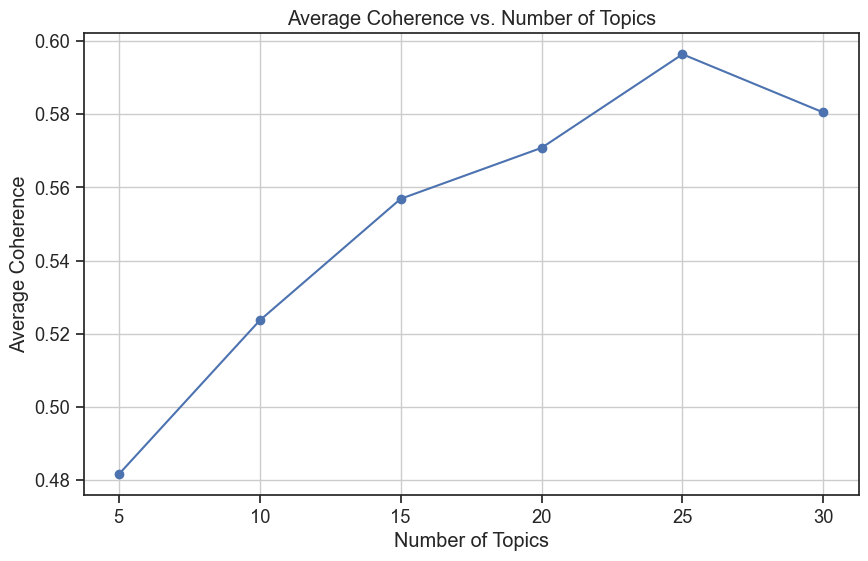

In [18]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model
import matplotlib.pyplot as plt

def plot_coherence(min_topics, max_topics, step, training_data, num_topic_words):
    coherence_scores = []
    num_topics_list = []
    
    for num_topics in range(min_topics, max_topics+1, step):
        # Initialize and train the LDA model
        model = tp.LDAModel(k=num_topics)
        for text in training_data:
            model.add_doc(text.split())
        model.train(iter=100)  # Train the model for 100 iterations
        
        # Calculate coherence score
        coh = tp.coherence.Coherence(model, coherence='c_v')
        average_coherence = coh.get_score()
        coherence_scores.append(average_coherence)
        num_topics_list.append(num_topics)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_list, coherence_scores, marker='o')
    plt.title('Average Coherence vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence')
    plt.grid(True)
    plt.show()

plot_coherence(min_topics=5, max_topics=30, step=5, training_data=training_data, num_topic_words=10)


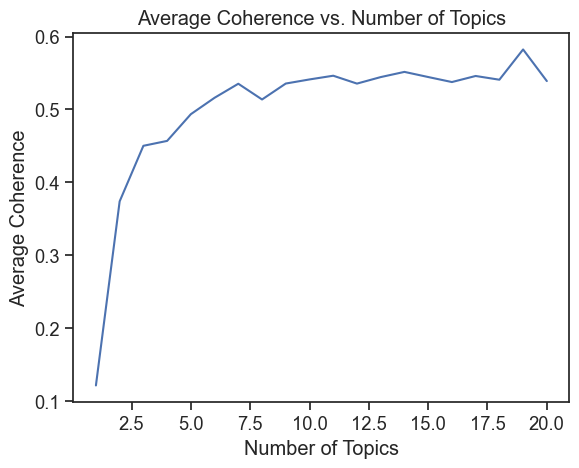

In [28]:
def plot_coherence(start_num, end_num, training_data):
    average_coherence_list =[]
    topics_num_list = range(start_num, end_num+1)
    for num_topics in topics_num_list:
        model = tp.LDAModel(k=num_topics)
        for tweet in training_data:
            model.add_doc(tweet.strip().split())
            iterations =10
        for i in range(0,100, iterations):
            model.train(iterations)
        coh = tp.coherence.Coherence(model, coherence='c_v')
        average_coherence_list.append(coh.get_score())
        
    plt.plot(topics_num_list, average_coherence_list)
    plt.title('Average Coherence vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence')
    plt.show()
    
# Test:plot coherence(1,20,training_data)
plot_coherence(1,20,training_data)

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [86]:
# Q7a (code)
def get_top_docs(docs, topic_distributions, topics, topic_index, n=5):
    # Check if the selected topic index is valid
    if topic_index >= len(topic_distributions):
        print(f"Error: Topic index {topic_index} is out of range. Number of topics in the model: {len(topic_distributions)}")
        return
    
    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)
    
    topic_words = topics[topic_index]
    
    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")
    
    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)
        
        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')
    
    return

topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

# Display 3 documents for topic 1，2，3，4

topics_of_interest = [1, 2, 3, 4]  

# Loop through the topics of interest and display the top documents for each topic
for topic_id in topics_of_interest:
    print(f"Top documents for Topic {topic_id}:")
    get_top_docs(original_texts, topic_distributions, topics, topic_index=topic_id, n=3)

Top documents for Topic 1:


### ✨Topic 1✨

great president north korea meeting forward amp united thank states



---


✨  
**Topic Probability**: 0.7942520380020142  
**Document**: If one person loses their insurance because of the Republican health care plan, that's too many. But 24 million? That’s an abomination.



✨  
**Topic Probability**: 0.7942520380020142  
**Document**:  The Mueller Report, despite being written by Angry Democrats and Trump Haters, and with unlimited money behind it ($35,000,000), didn’t lay a glove on me. I DID NOTHING WRONG. If the partisan Dems ever tried to Impeach, I would first head to the U.S. Supreme Court. Not only......



✨  
**Topic Probability**: 0.7438201904296875  
**Document**:  “21 State Attorney Generals denouncing the Impeachment of President Trump.” @FoxNews



Top documents for Topic 2:


### ✨Topic 2✨

health care people must right country change every climate need



---


✨  
**Topic Probability**: 0.8257099390029907  
**Document**: We don’t **need** more austerity for the middle class. We don’t **need** to cut Medicare and Medicaid. It is time for some austerity for the top 1%.



✨  
**Topic Probability**: 0.7913990020751953  
**Document**: Over 100 years ago workers demanded a 40 hour workweek. Here we are in 2017 and the average full-time American worker works 47 hours a week!



✨  
**Topic Probability**: 0.7797039151191711  
**Document**: The surefire route to success in politics has been to manipulate **people**'s fear and ignorance. We can and will **change** that.



Top documents for Topic 3:


### ✨Topic 3✨

border wall amp democrats immigration law security must illegal country



---


✨  
**Topic Probability**: 0.9289044737815857  
**Document**:  RT @GOPLeader: The Republican coalition is bigger, more diverse, and more energetic than ever before—thanks to President @realDonaldTrump. His efforts to reach every demographic has positively expanded the future of the GOP.   Join me for a news conference starting soon. https://t.co/5zXyrK785h



✨  
**Topic Probability**: 0.9104855060577393  
**Document**: More proof that this administration wants to rig the 2020 Census to undercount minorities—and they’re trying to cover it up. The census **must** not be turned into a partisan weapon. Immigrant communities have a right to equal representation and funding. https://t.co/6Vtmdf1rXD



✨  
**Topic Probability**: 0.9104855060577393  
**Document**: I say to Mitch McConnell: Do not ignore the will of 200 million Americans who want us to put an end to starvation wages in the United States.

Let the American people have a vote on a $15 minimum wage! https://t.co/p0uaE6mMo9



Top documents for Topic 4:


### ✨Topic 4✨

rt trump president biden amp coronavirus joe donald new covid19



---


✨  
**Topic Probability**: 0.8711323738098145  
**Document**: When we see demonstrations of white supremacy, we must be unequivocal in our condemnation, as our **president** shamefully was not. #BernieFP



✨  
**Topic Probability**: 0.8711323738098145  
**Document**: We cannot roll back the clock on whether women can make decisions about their own bodies. https://t.co/5oCAYXJdiG



✨  
**Topic Probability**: 0.8470975160598755  
**Document**: Even as Trump draws closer to authoritarian leaders like Putin, Orban in Hungary, Erdogan in Turkey, Duterte in the Philippines, and North Korea’s Kim Jong Un, Trump is needlessly increasing tensions with our democratic European allies. #SandersSAIS



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

In [ ]:
# Q7b (words)
#Topic 1:
##Top tweets: These tweets primarily focus on healthcare and criticism of Republican policies, indicating a concern for healthcare accessibility and opposition to Republican proposals.
##Representative of: Bernie Sanders. This topic aligns with Sanders' emphasis on healthcare reform and his opposition to Republican healthcare plans.

#Topic 2:
##Top tweets: These tweets discuss issues related to workers' rights, climate change, and the need for social change, reflecting progressive views on these topics.
##Representative of: Bernie Sanders. This topic resonates with Sanders' advocacy for workers' rights, addressing climate change, and promoting social justice.

#Topic 3:
##Top tweets: These tweets focus on immigration, border security, and criticism of the Trump administration's policies, highlighting concerns about immigration laws and the treatment of immigrants.
##Representative of: Bernie Sanders. While immigration is a topic of concern for both politicians, the criticism of the Trump administration's immigration policies aligns more closely with Sanders' views.

#Topic 4:
##Top tweets: These tweets mention various political figures, including Trump, Biden, and other issues like coronavirus, reflecting a broader political discourse.
##Representative of: Both politicians. This topic covers a range of political figures and issues, making it less specific to either Sanders or Trump.

#Overall, topics 1, 2, and 3 have top tweets that are more aligned with Bernie Sanders' views, as they focus on healthcare, workers' rights, climate change, and immigration policies, which are key issues in Sanders' platform. Topic 4 covers a broader political landscape and is less indicative of a specific politician's views.

## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [62]:
# Crete a sample of tweets

from random import sample

target_labels = sample(titles,100)

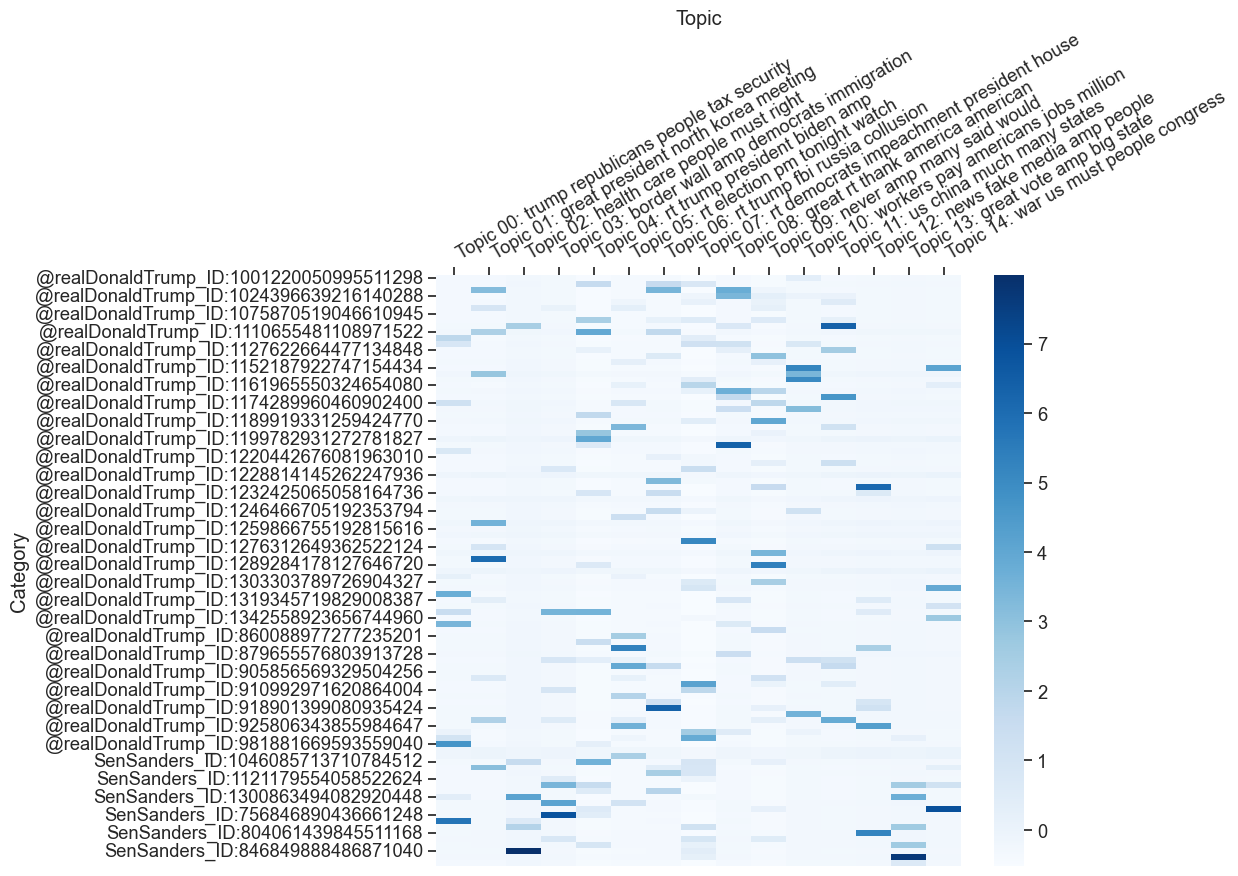

In [80]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map='Blues',
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                if _topic_index < len(topic_keys):  # Check if _topic_index is within range of topic_keys
                    dicts_to_plot.append({'Probability': float(_probability),
                                          'Category': _label,
                                          'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe from the dictionaries.
    import pandas as pd
    df_to_plot = pd.DataFrame(dicts_to_plot)

    # Pivot the dataframe to wide format and normalize the columns.
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()

    # Create the heatmap using Seaborn.
    plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()

    # Show the plot.
    plt.show()

# Assuming titles, topic_distributions, topic_individual_words, and target_labels are defined
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map='Blues',
                                  dim=(12, 9))
    

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

In [ ]:
# Q9 
# When compared to everyone else in the heatmap, the darker squares in this one indicate a higher probability for the related issue, and the lighter squares indicate a lower chance.(words)
##Topic02 and Topic13 have the darkest color, representing the most likelihood belonging to Sanders.
##Trump's colors are more intense in the middle, while Sanders's are scattered on two sides. Moreover, the latter one has more percentage of darker cubes than the former.

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [82]:
# X2（code）
# Sample 50 tweets from each author
sample_trump = trump_tweets_df.sample(n=50, random_state=42)
sample_sanders = sanders_tweets_df.sample(n=50, random_state=42)

# Concatenate the balanced samples
balanced_sample = pd.concat([sample_trump, sample_sanders], ignore_index=True)

# Check the shape of the balanced sample
print("Balanced sample shape:", balanced_sample.shape)



Balanced sample shape: (100, 4)


### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [89]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)


In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map='Blues',
                                      dim=None):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                if _topic_index < len(topic_keys):  # Check if _topic_index is within range of topic_keys
                    dicts_to_plot.append({'Probability': float(_probability),
                                          'Category': _label,
                                          'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe from the dictionaries.
    import pandas as pd
    df_to_plot = pd.DataFrame(dicts_to_plot)

    # Pivot the dataframe to wide format and normalize the columns.
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()
    # Calculate summary statistics
    summary_stats = df_norm_col.describe()
    print(summary_stats)

    # Visualize the data using box plots
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_norm_col)
    plt.title('Box Plot of Normalized Topic Distributions')
    plt.xlabel('Topics')
    plt.ylabel('Normalized Probability')
    plt.xticks(rotation=45)
    plt.show()